In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import smooth, tilt_distance_LI

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150,150,:]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_eddies

,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


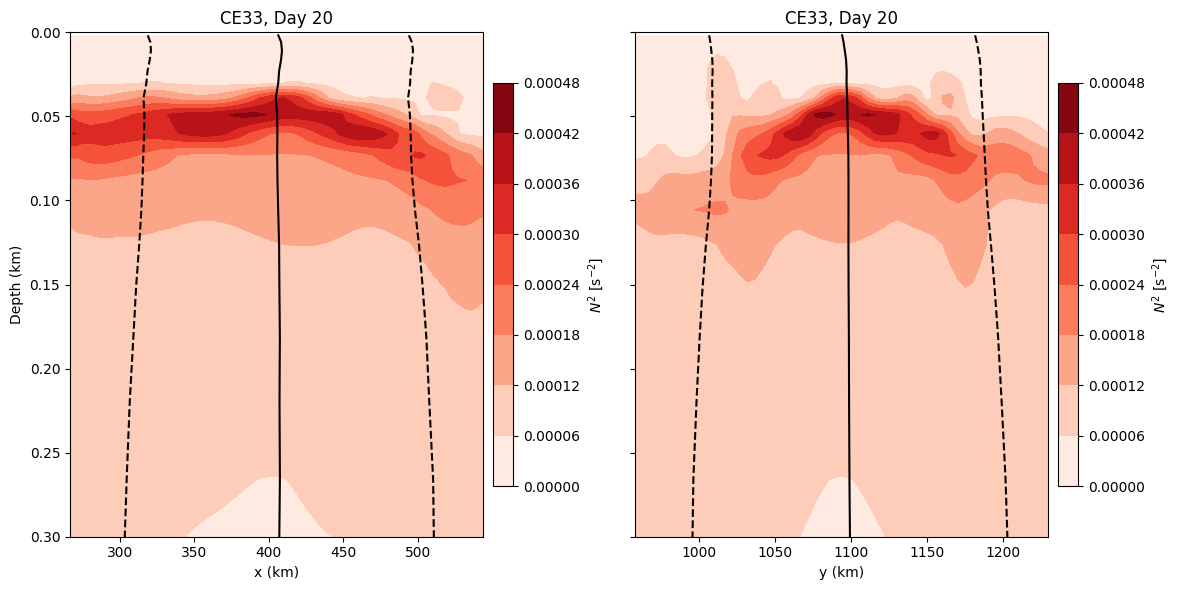

In [4]:
eddy = 33
day_idx = 20

try:
    fnumber_old
except NameError:
    fnumber_old = None

df_eddy = df_eddies[df_eddies.Eddy == eddy]
data = df_eddy.iloc[day_idx]

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax0, ax1 = axs

r = 140
cyc = df_eddy.iloc[0].Cyc
ax0.set_title(f'{cyc}{eddy}, Day {day_idx}')
ax1.set_title(f'{cyc}{eddy}, Day {day_idx}')

dic = dic_eddies_vert[f'Eddy{eddy}']
df = dic[f'Day{data.Day}'].copy()

Rcs = df.Rc.values.copy()
depths_km = -df.Depth.values.copy() / 1000
df['sRc'] = smooth(Rcs, depths_km, window=50, num=1000)

fname = data.fname
fnumber = int(fname[-8:-3])
if fnumber != fnumber_old:
    N2 = np.load(f'/srv/scratch/z5297792/Climatology/N2s/N2s/N2_{fnumber:05}.npy')
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == data.Day)[0][0]

xc_surf, yc_surf = df.iloc[0][['x', 'y']]
ic = np.argmin(np.abs(x_grid - xc_surf))
jc = np.argmin(np.abs(y_grid - yc_surf))

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]

z_km = -z_r / 1000
depth_mask = (z_km >= 0.0) & (z_km <= .4)

slice_x = N2[x_mask, jc, :, t_rel][:, depth_mask]
slice_y = N2[ic, y_mask, :, t_rel][:, depth_mask]
z_plot = z_km[depth_mask]

# with np.errstate(all='ignore'):
#     vmax_v = np.nanmax(np.abs(slice_x))
#     vmax_u = np.nanmax(np.abs(slice_y))
# vmax_v = 0.0 if not np.isfinite(vmax_v) else vmax_v
# vmax_u = 0.0 if not np.isfinite(vmax_u) else vmax_u

im0 = ax0.contourf(x_grid[x_mask], z_plot, slice_x.T, cmap='Reds',
                   vmin=None, vmax=None, zorder=0)
ax0.plot(df.x, depths_km, color='k')
ax0.plot(df.x + df.sRc, depths_km, color='k', ls='--', zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
ax0.plot(df.x - df.sRc, depths_km, color='k', ls='--', zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
ax0.plot([df.iloc[-1].x - df.iloc[-1].sRc, df.iloc[-1].x + df.iloc[-1].sRc],
         [depths_km[-1], depths_km[-1]], color='k', ls='--',
         zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
ax0.set_xlabel('x (km)')
ax0.set_ylabel('Depth (km)')
ax0.plot(x_grid[x_mask], h[x_mask, jc] / 1000, 'k', zorder=2)
ax0.fill_between(x_grid[x_mask], h[x_mask, jc] / 1000, 10, color='k', zorder=2)

cbar0 = fig.colorbar(im0, ax=ax0, orientation='vertical', pad=0.02, shrink=0.8)
cbar0.set_label(r'$N^2$ [s$^{-2}$]')

im1 = ax1.contourf(y_grid[y_mask], z_plot, slice_y.T, cmap='Reds',
                   vmin=None, vmax=None, zorder=0)
ax1.plot(df.y, depths_km, color='k')
ax1.plot(df.y + df.sRc, depths_km, color='k', ls='--', zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
ax1.plot(df.y - df.sRc, depths_km, color='k', ls='--', zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
ax1.plot([df.iloc[-1].y - df.iloc[-1].sRc, df.iloc[-1].y + df.iloc[-1].sRc],
         [depths_km[-1], depths_km[-1]], color='k', ls='--',
         zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
ax1.set_xlabel('y (km)')
ax1.plot(y_grid[y_mask], h[ic, y_mask] / 1000, 'k', zorder=2)
ax1.fill_between(y_grid[y_mask], h[ic, y_mask] / 1000, 10, color='k', zorder=2)

cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', pad=0.02, shrink=0.8)
cbar1.set_label(r'$N^2$ [s$^{-2}$]')

ax0.invert_yaxis()
ax0.set_ylim(.3, 0)
ax1.set_ylim(.3, 0)

plt.tight_layout()
plt.show()


(-300.0, 0.0)

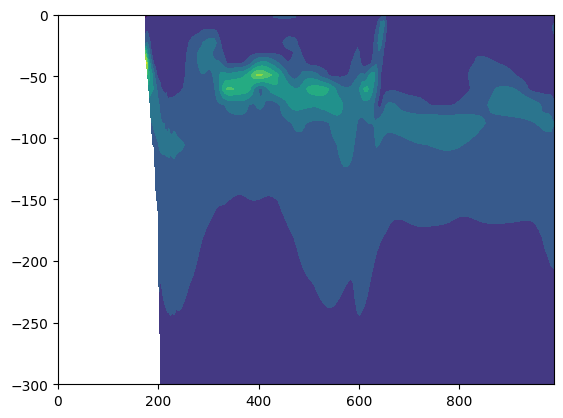

In [5]:
plt.contourf(x_grid, z_r, N2[:, 100, :, 0].T)
plt.ylim(-300, 0)


### Li Analysis

(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

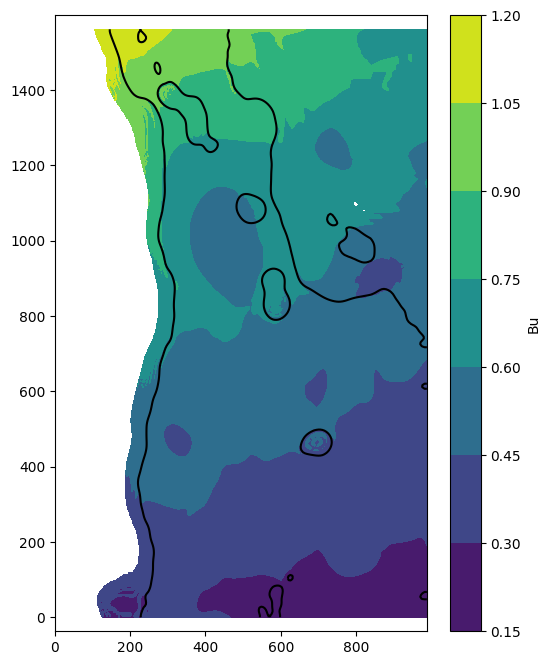

In [6]:
fnum = 1461
Nbar = np.load(f'/srv/scratch/z5297792/Climatology/N2s/Nbars_300m_depth/Nbar_{fnum:05}.npy')
N2 = np.load(f'/srv/scratch/z5297792/Climatology/N2s/N2s/N2_{fnum:05}.npy')
H = 300

Bu = ( (np.mean(Nbar, axis=2) * H) / (f * 50000) )**2
# Bu = ( (Nbar[:,:,0] * H) / (f * 50000) )**2
Bu = np.where(mask_rho, Bu, np.nan)
Bu = np.where(h > H, Bu, np.nan)

plt.figure(figsize=(6, 8))
plt.contourf(X_grid, Y_grid, Bu)
plt.colorbar(label='Bu')
plt.contour(X_grid, Y_grid, h, levels=[4000], colors='k')
plt.axis('equal')


In [ ]:
fnumber_old = 0
Bu = []
H = 300
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    fname = data.fname
    fnumber = int(data.fname[-8:-3])
    if fnumber != fnumber_old:
        Nbar = np.load(f'/srv/scratch/z5297792/Climatology/N2s/Nbars_300m_depth/Nbar_{fnumber:05}.npy')
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == data.Day)[0][0]
    
    ic, jc, r = data.ic, data.jc, data.Rc
    i_mask, j_mask = np.where(np.hypot(X_grid[ic, jc]-X_grid, Y_grid[ic, jc]-Y_grid) < r)
    Nbar_local = np.nanmean(Nbar[i_mask, j_mask, t_rel])
    h_local = min(H, np.nanmean(h[i_mask, j_mask]))
    f_local = np.nanmean(f[i_mask, j_mask])

    Bu.append( ((Nbar_local * h_local) / (f_local * data.Rc * 1000))**2 )

df_eddies['Bu'] = Bu


Slope: 0.022916651304247325
Intercept: 22.42404920599274
R²: 0.00036361406170455076
p-value: 1.0727044924610297e-07
Standard error: 0.0043121345719485974


(0.0, 14.0)

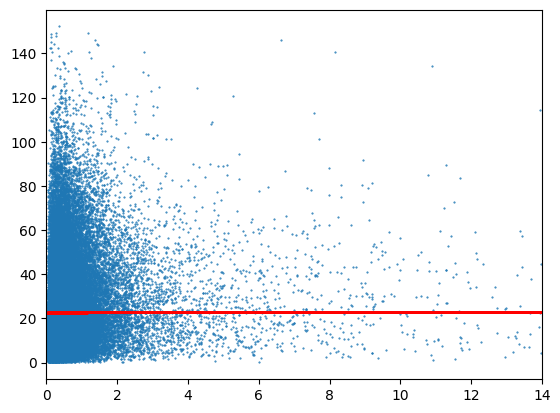

In [19]:
from scipy.stats import linregress

df = df_eddies.copy().dropna()
df = df[h[df.ic, df.jc] > H]

y = df.TiltDis
x = df.Bu # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.')
plt.plot(x, slope*x + intercept, color='red')
plt.xlim(0, 14)


In [16]:
LiTD = []
H = 300
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    dic = dic_eddies_vert[f'Eddy{data.Eddy}']
    df = dic[f'Day{data.Day}'].copy()
    if len(df):
        TD, _, _ = tilt_distance_LI(df.x, df.y, -df.Depth, zmin=0, zmax=H)
        LiTD.append(TD)
    else:
        LiTD.append(np.nan)
df_eddies['LiTD'] = LiTD


Slope: 0.020694364588074818
Intercept: 18.236059752285723
R²: 0.0004902402151532363
p-value: 6.810194639275342e-10
Standard error: 0.0033533710043374423


(0.0, 14.0)

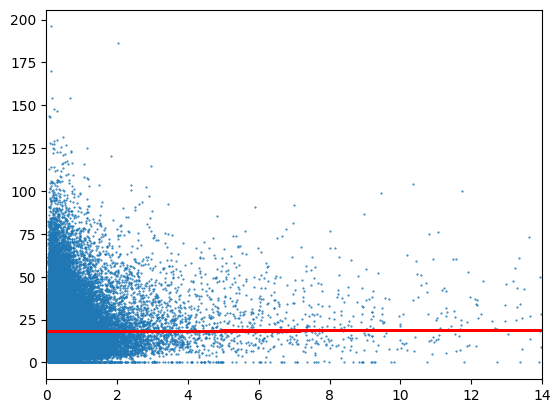

In [21]:
df = df_eddies.copy().dropna()
df = df[h[df.ic, df.jc] > H]

y = df.LiTD
x = df.Bu # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.')
plt.plot(x, slope*x + intercept, color='red')
plt.xlim(0, 14)


In [ ]:
break

In [ ]:
plt.figure(figsize=(6,8))
plt.contourf(X_grid, Y_grid, N2[:,:,5,0])
plt.colorbar()
plt.axis('equal')


In [ ]:
# df_test = df_eddies[df_eddies.Day<=2271].copy()
df_test = df_eddies.copy()
df_test


In [ ]:
fnumber_old = 0
Bu = []
H = 300
for k in range(len(df_test)):
    data = df_test.iloc[k]
    fname = data.fname
    fnumber = int(data.fname[-8:-3])
    if fnumber != fnumber_old:
        Nbar = np.load(f'/srv/scratch/z5297792/Climatology/N2s/N2s_300m_depth/Nbar_{fnumber:05}.npy')
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == data.Day)[0][0]
    
    ic, jc, r = data.ic, data.jc, data.Rc
    i_mask, j_mask = np.where(np.hypot(X_grid[ic, jc]-X_grid, Y_grid[ic, jc]-Y_grid) < r)
    Nbar_local = np.nanmean(Nbar[i_mask, j_mask, t_rel])
    # Bu.append( ((Nbar_local * h[data.ic, data.jc]) / (f[data.ic, data.jc] * data.Rc * 1000))**2 )
    Bu.append(Nbar_local)
    
    # Bu.append( ((Nbar[data.ic, data.jc, t_rel] * h[data.ic, data.jc]) / (f[data.ic, data.jc] * data.Rc * 1000))**2 )
    
df_test['Bu'] = Bu


In [ ]:
from scipy.stats import linregress

df = df_test.copy().dropna()
df = df[h[df.ic, df.jc] > 1000]

y = df.TiltDis
x = np.log10(df.Bu) # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.')
plt.plot(x, slope*x + intercept, color='red')


In [ ]:
plt.figure(figsize=(7,6))
field = np.where(h > 1000, Nbar[:,:,0], np.nan)
field = np.where(mask_rho, field, np.nan)
plt.contourf(lon_rho, lat_rho, field)
plt.colorbar()
plt.axis('equal')


In [ ]:
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_ave_1000m.npy')
plt.figure(figsize=(7,6))
field = np.where(h > 1000, Nbar_ave, np.nan)
field = np.where(mask_rho, field, np.nan)
plt.pcolor(lon_rho, lat_rho, field)
plt.colorbar()
plt.axis('equal')


In [ ]:
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_ave_1000m.npy')
plt.figure(figsize=(7,6))
field = np.where(h > 1000, Nbar_ave, np.nan)
field = np.where(mask_rho, field, np.nan)

Bu = ( (field * h) / (f * 50000) )**2

plt.pcolor(lon_rho, lat_rho, Bu)
plt.colorbar()
plt.axis('equal')
